### HighIQ spectral processing example.

This notebook demonstrates how to process Doppler spectra from complex autocorrelation function (ACF) data using HighIQ. The example data come from the Atmospheric Radiation Measurement program's Doppler Lidar at the Southern Great Plains (SGP) site in Oklahoma.

In [1]:
import highiq
import numpy as np
import matplotlib.pyplot as plt
import act
import cmweather  # noqa

%matplotlib inline

/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/moments.py:12: Warning: CuPy not installed...reverting to Numpy!
  warnings.warn("CuPy not installed...reverting to Numpy!", Warning)
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/spectra.py:12: Warning: CuPy not installed...reverting to Numpy!
  warnings.warn("CuPy not installed...reverting to Numpy!", Warning)
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/spectra.py:12: Warning: CuPy not installed...reverting to Numpy!
  warnings.warn("CuPy not installed...reverting to Numpy!", Warning)


HighIQ uses xarray as its primary data model. If you have ACF data in netCDF format, HighIQ can load it directly without preprocessing. The input dataset must provide two four-dimensional arrays with dimensions (time, samples, lags, real/complex component), as shown in the example dataset below.

To follow this notebook you can download an example ARM netCDF file using ACT's discovery module. You will need an ARM Facility account and an ARM Live token. Obtain your token from ARM Live (https://adc.arm.gov/armlive/#scripts) using your ARM username.

In [6]:
username = ""  # replace with your own ARM username
token = ""  # replace with your own token
act.discovery.download_arm_data(
    username, token, "cordlacfM1.a1", "2018-11-01T00:00:00", "2018-11-01T01:00:00"
)

[DOWNLOADING] cordlacfM1.a1.20181101.000014.nc
[DOWNLOADING] cordlacfM1.a1.20181101.000058.nc
[DOWNLOADING] cordlacfM1.a1.20181101.001505.nc
[DOWNLOADING] cordlacfM1.a1.20181101.003004.nc
[DOWNLOADING] cordlacfM1.a1.20181101.004504.nc

If you use these data to prepare a publication, please cite:

Cromwell, E., Newsom, R., & Krishnamurthy, R. Doppler Lidar (DLACF), 2018-11-01
to 2018-11-01, ARM Mobile Facility (COR), Cordoba, Argentina; AMF1 (main site
for CACTI) (M1). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1393859



['/Users/rjackson/HighIQ/notebooks/cordlacfM1.a1/cordlacfM1.a1.20181101.000014.nc',
 '/Users/rjackson/HighIQ/notebooks/cordlacfM1.a1/cordlacfM1.a1.20181101.000058.nc',
 '/Users/rjackson/HighIQ/notebooks/cordlacfM1.a1/cordlacfM1.a1.20181101.001505.nc',
 '/Users/rjackson/HighIQ/notebooks/cordlacfM1.a1/cordlacfM1.a1.20181101.003004.nc',
 '/Users/rjackson/HighIQ/notebooks/cordlacfM1.a1/cordlacfM1.a1.20181101.004504.nc']

In [2]:
my_ds = highiq.io.load_arm_netcdf("cordlacfM1.a1/cordlacfM1.a1.20181101.000058.nc")

In [3]:
my_ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 3321, nsamples: 3200, nlags: 7, complex: 2)
Coordinates:
  * time         (time) datetime64[ns] 27kB 2018-11-01T00:00:58.020000 ... 20...
  * complex      (complex) int16 4B 0 1
Dimensions without coordinates: nsamples, nlags
Data variables:
    base_time    datetime64[ns] 8B ...
    time_offset  (time) datetime64[ns] 27kB ...
    azimuth      (time) float32 13kB ...
    elevation    (time) float32 13kB ...
    acf_bkg      (time, nsamples, nlags, complex) float32 595MB 2.041e+08 ......
    acf          (time, nsamples, nlags, complex) float32 595MB ...
    lat          float32 4B ...
    lon          float32 4B ...
    alt          float32 4B ...
Attributes: (12/23)
    command_line:               dlacf_ingest -s cor -f M1 -DR --max-runtime 0
    Conventions:                ARM-1.2
    process_version:            ingest-dlacf-1.1-0.el6
    dod_version:                dlacf-a1-1.1
    input_source:               /data/collection/cor/cordlacfM1.00/aet_Stare_...
    site_id:                    cor
    ...                         ...
    dlon:                       -64.72854
    target_latitude:            -32.12337
    target_longitude:           -64.72717
    target_altitude:            1136
    home_point_azimuth:         285.38
    history:                    created by user dsmgr on machine ruby at 2019...

The first step is to compute Doppler power spectral densities (PSDs) from the ACFs. HighIQ expects an xarray Dataset with the ACFs arranged as above. The ACFs are discrete functions (typically 7 or 20 lags). For each signal ACF we compute the PSD as the discrete Fourier transform (DFT) of the zero-lag normalized ACF, and normalize it by the DFT of the zero-lag normalized background ACF.

In [4]:
ds = highiq.calc.get_psd(my_ds, nfft=1024, time_window=5, gate_resolution=30.0)

/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/spectra.py:129: RuntimeWarning: invalid value encountered in divide
  complex_coeff = complex_coeff / cp.tile(
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/spectra.py:172: RuntimeWarning: invalid value encountered in divide
  complex_coeff_bkg = complex_coeff_bkg / cp.tile(


## Plotting power spectra

You can plot PSDs using xarray's .sel and .plot() methods. Below is an example showing how to select a time and range gate and plot the PSD for that gate.

In [5]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:                 (complex: 2, time: 709, freq: 1024, vel_bins: 1024,
                             range: 320)
Coordinates:
  * complex                 (complex) int16 4B 0 1
  * time                    (time) datetime64[ns] 6kB 2018-11-01T00:00:55 ......
  * vel_bins                (vel_bins) float64 8kB -19.35 -19.31 ... 19.27 19.31
  * range                   (range) float64 3kB 0.0 30.0 ... 9.54e+03 9.57e+03
Dimensions without coordinates: freq
Data variables:
    base_time               (time) datetime64[ns] 6kB 2018-11-01 ... 2018-11-01
    time_offset             (time) datetime64[ns] 6kB 2018-11-01T00:00:58.540...
    azimuth                 (time) float32 3kB 127.9 15.38 15.38 ... 15.38 15.38
    elevation               (time) float32 3kB 75.0 90.0 90.0 ... 90.0 90.0 90.0
    lat                     (time) float32 3kB -32.13 -32.13 ... -32.13 -32.13
    lon                     (time) float32 3kB -64.73 -64.73 ... -64.73 -64.73
    alt                     (time) float32 3kB 1.141e+03 1.141e+03 ... 1.141e+03
    freq_bins               (freq) float64 8kB -2.5e+07 -2.495e+07 ... 2.495e+07
    power_spectral_density  (time, range, vel_bins) float64 2GB 0.9991 ... 1.003
Attributes: (12/24)
    command_line:               dlacf_ingest -s cor -f M1 -DR --max-runtime 0
    Conventions:                ARM-1.2
    process_version:            ingest-dlacf-1.1-0.el6
    dod_version:                dlacf-a1-1.1
    input_source:               /data/collection/cor/cordlacfM1.00/aet_Stare_...
    site_id:                    cor
    ...                         ...
    target_latitude:            -32.12337
    target_longitude:           -64.72717
    target_altitude:            1136
    home_point_azimuth:         285.38
    history:                    created by user dsmgr on machine ruby at 2019...
    nyquist_velocity:           19.350000 m s-1

To get the lidar moments, just use `highiq.calc.get_lidar_moments`.

In [6]:
ds = highiq.calc.get_lidar_moments(ds)

/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/moments.py:45: RuntimeWarning: divide by zero encountered in divide
  gpu_array = 1 / power_array * cp.sum(gpu_array * vel_bins_tiled, axis=2)
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/moments.py:45: RuntimeWarning: invalid value encountered in multiply
  gpu_array = 1 / power_array * cp.sum(gpu_array * vel_bins_tiled, axis=2)
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/moments.py:77: RuntimeWarning: divide by zero encountered in divide
  1
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/highiq/calc/moments.py:76: RuntimeWarning: invalid value encountered in sqrt
  gpu_array = cp.sqrt(


In [7]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:                   (complex: 2, time: 709, freq: 1024,
                               vel_bins: 1024, range: 320)
Coordinates:
  * complex                   (complex) int16 4B 0 1
  * time                      (time) datetime64[ns] 6kB 2018-11-01T00:00:55 ....
  * vel_bins                  (vel_bins) float64 8kB -19.35 -19.31 ... 19.31
  * range                     (range) float64 3kB 0.0 30.0 ... 9.54e+03 9.57e+03
Dimensions without coordinates: freq
Data variables: (12/15)
    base_time                 (time) datetime64[ns] 6kB 2018-11-01 ... 2018-1...
    time_offset               (time) datetime64[ns] 6kB 2018-11-01T00:00:58.5...
    azimuth                   (time) float32 3kB 127.9 15.38 ... 15.38 15.38
    elevation                 (time) float32 3kB 75.0 90.0 90.0 ... 90.0 90.0
    lat                       (time) float32 3kB -32.13 -32.13 ... -32.13 -32.13
    lon                       (time) float32 3kB -64.73 -64.73 ... -64.73 -64.73
    ...                        ...
    intensity                 (time, range) float64 2MB 1.0 1.001 ... 1.0 1.0
    radial_velocity_max_peak  (time, range) float64 2MB -5.593 0.3779 ... 16.29
    radial_velocity           (time, range) float64 2MB -5.884e+03 ... 2e+04
    spectral_width            (time, range) float64 2MB 2.91e+04 ... 9.89e+04
    skewness                  (time, range) float64 2MB 0.1939 0.1939 ... -0.194
    kurtosis                  (time, range) float64 2MB 0.03753 ... 0.03755
Attributes: (12/25)
    command_line:               dlacf_ingest -s cor -f M1 -DR --max-runtime 0
    Conventions:                ARM-1.2
    process_version:            ingest-dlacf-1.1-0.el6
    dod_version:                dlacf-a1-1.1
    input_source:               /data/collection/cor/cordlacfM1.00/aet_Stare_...
    site_id:                    cor
    ...                         ...
    target_longitude:           -64.72717
    target_altitude:            1136
    home_point_azimuth:         285.38
    history:                    created by user dsmgr on machine ruby at 2019...
    nyquist_velocity:           19.350000 m s-1
    intensity_mask:             0.000000

Let's take a look at the power spectral density at a specific time and range gate. At this range gate, we expect to see
a single Gaussian peak. The power spectral density is normalized such that a PSD of 1 is at the noise floor of the instrumnent. Below, we do see a peak that is wider than Gaussian, with the highest power at about -3 m/s. This is indicative of either a strong downdraft or drizzle being present at this gate. While there are other "bumps", these are present with signal to noise ratios of less than 1, likely indicating instrument noise.

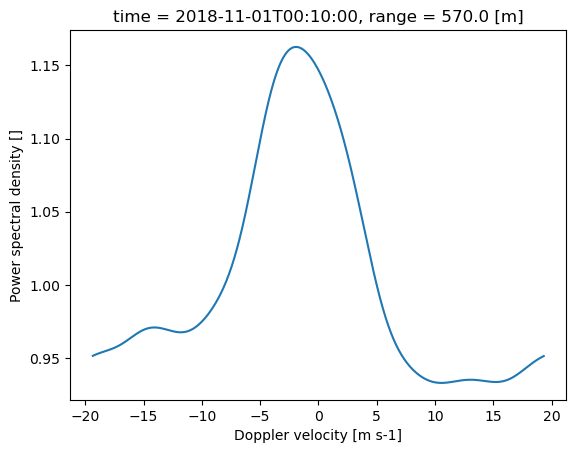

In [8]:
ds["power_spectral_density"].sel(
    time="2018-11-01T00:10:00", range=570, method="nearest"
).plot()

To estimate signal-to-noise ratio (SNR) from the PSD, we convert intensity to dB: compute 10*log10(intensity - 1), where intensity is normalized so that a PSD of 1 corresponds to the instrument noise floor. This helps identify the useful dynamic range for moment calculations.

/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/rjackson/miniforge3/envs/highiq_dev/lib/python3.14/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


Text(0.5, 0, 'SNR (dB)')

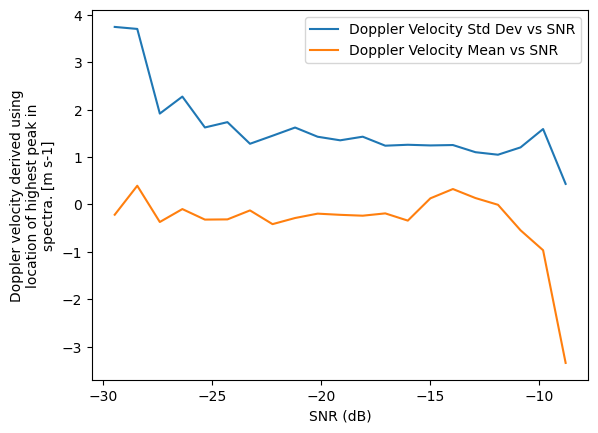

In [9]:
ds["radial_velocity_max_peak"].groupby_bins(
    np.log10(ds["intensity"] - 1) * 10, bins=np.linspace(-30, 0, 30)
).std().plot(label="Doppler Velocity Std Dev vs SNR")
ds["radial_velocity_max_peak"].groupby_bins(
    np.log10(ds["intensity"] - 1) * 10, bins=np.linspace(-30, 0, 30)
).mean().plot(label="Doppler Velocity Mean vs SNR")
plt.legend()
plt.xlabel("SNR (dB)")

Let's plot filtered Doppler velocity and intensity time series. We apply a stricter mask to exclude low-SNR samples and then use ACT's TimeSeriesDisplay to visualize intensity and Doppler velocity side-by-side.

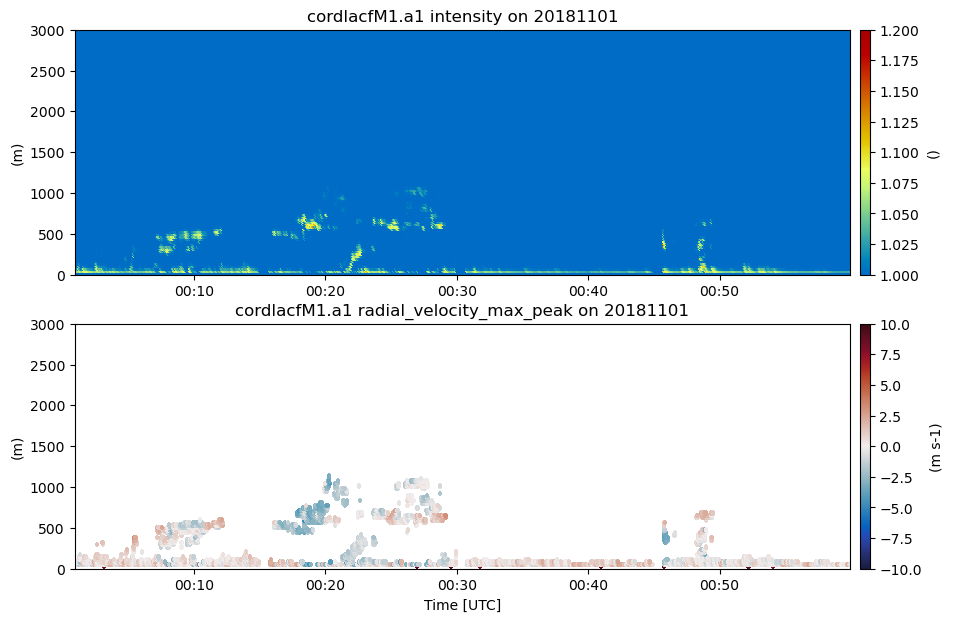

In [18]:
# Make a stricter mask for Doppler velocity to favor excluding more noise (-25 dB from above analysis)
ds["radial_velocity_max_peak"] = ds["radial_velocity_max_peak"].where(
    ds.intensity > (1 + 10 ** (-27 / 10))
)

# With ACT, we set up a TimeSeriesDisplay object with two sub plots
my_display = act.plotting.TimeSeriesDisplay(ds, figsize=(10, 7), subplot_shape=(2,))

# The plot function takes in the same kwargs as matplotlib's plotting routines
my_display.plot(
    "intensity", subplot_index=(0,), cmap="HomeyerRainbow", vmin=1, vmax=1.2
)
my_display.plot(
    "radial_velocity_max_peak", subplot_index=(1,), cmap="balance", vmin=-10, vmax=10
)
my_display.set_yrng([0, 3000], subplot_index=(0,))
my_display.set_yrng([0, 3000], subplot_index=(1,))
my_display.fig.savefig("spectra_difference.png", dpi=300)

In [14]:
ds = highiq.calc.calc_num_peaks(ds, prominence=0.1)
ds

<xarray.Dataset> Size: 2GB
Dimensions:                   (complex: 2, time: 709, freq: 1024,
                               vel_bins: 1024, range: 320, peak_no: 5)
Coordinates:
  * complex                   (complex) int16 4B 0 1
  * time                      (time) datetime64[ns] 6kB 2018-11-01T00:00:55 ....
  * vel_bins                  (vel_bins) float64 8kB -19.35 -19.31 ... 19.31
  * range                     (range) float64 3kB 0.0 30.0 ... 9.54e+03 9.57e+03
Dimensions without coordinates: freq, peak_no
Data variables: (12/17)
    base_time                 (time) datetime64[ns] 6kB 2018-11-01 ... 2018-1...
    time_offset               (time) datetime64[ns] 6kB 2018-11-01T00:00:58.5...
    azimuth                   (time) float32 3kB 127.9 15.38 ... 15.38 15.38
    elevation                 (time) float32 3kB 75.0 90.0 90.0 ... 90.0 90.0
    lat                       (time) float32 3kB -32.13 -32.13 ... -32.13 -32.13
    lon                       (time) float32 3kB -64.73 -64.73 ... -64.73 -64.73
    ...                        ...
    radial_velocity           (time, range) float64 2MB nan nan ... nan nan
    spectral_width            (time, range) float64 2MB 2.91e+04 ... 9.89e+04
    skewness                  (time, range) float64 2MB 0.1939 0.1939 ... -0.194
    kurtosis                  (time, range) float64 2MB 0.03753 ... 0.03755
    npeaks                    (time, range) float64 2MB 0.0 0.0 1.0 ... 0.0 0.0
    peak_velocities           (time, range, peak_no) float64 9MB nan nan ... nan
Attributes: (12/25)
    command_line:               dlacf_ingest -s cor -f M1 -DR --max-runtime 0
    Conventions:                ARM-1.2
    process_version:            ingest-dlacf-1.1-0.el6
    dod_version:                dlacf-a1-1.1
    input_source:               /data/collection/cor/cordlacfM1.00/aet_Stare_...
    site_id:                    cor
    ...                         ...
    target_longitude:           -64.72717
    target_altitude:            1136
    home_point_azimuth:         285.38
    history:                    created by user dsmgr on machine ruby at 2019...
    nyquist_velocity:           19.350000 m s-1
    intensity_mask:             0.000000